**TTT-MIM: Test-Time Training with Masked Image Modeling Can Improve Denoising Performance under Distribution Shifts**

In this notebook, the test-time training (TTT) method based on masked image modeling (MIM) is applied to improve denoising performance for out-of-distribution images. At test-time, a selfsupervised loss is minimized to fine-tune the network to adapt to a single noisy image.

Download needed files from google drive.

In [1]:
# download needed files
!pip install gdown
!gdown https://drive.google.com/uc?id=1jXZpp5a6FcolVO8_Qx7HXlN9mO8jTah0
!unzip TTT_MIM_files.zip

Downloading...
From (original): https://drive.google.com/uc?id=1jXZpp5a6FcolVO8_Qx7HXlN9mO8jTah0
From (redirected): https://drive.google.com/uc?id=1jXZpp5a6FcolVO8_Qx7HXlN9mO8jTah0&confirm=t&uuid=82b2526d-51a5-4c9d-b208-74fcc73a07b7
To: /content/TTT_MIM_files.zip
100% 110M/110M [00:03<00:00, 27.6MB/s]
Archive:  TTT_MIM_files.zip
  inflating: dataset.py              
  inflating: loss.py                 
  inflating: model/0715_ttt_mim_unet_gn_0.005.pth.tar  
   creating: testset/fastmri_subset/
   creating: testset/fastmri_subset/gt/
  inflating: testset/fastmri_subset/gt/file1000537_slice_24.png  
  inflating: testset/fastmri_subset/gt/file1000818_slice_23.png  
  inflating: testset/fastmri_subset/gt/file1000976_slice_25.png  
  inflating: testset/fastmri_subset/gt/file1001064_slice_25.png  
  inflating: testset/fastmri_subset/gt/file1001763_slice_21.png  
  inflating: testset/fastmri_subset/gt/file1001851_slice_23.png  
  inflating: testset/fastmri_subset/gt/file1002412_slice_19.png 

### Test-Time Adaptation to Single Images

**Hyperparameters**
* --lr: Learning rate for the gradient updates during the Test-Time Training.
* --niters: Number of gradient update iterations during the Test-Time Training
* --mask-ratio: Mask ratio determines the fraction of the masked-off area.
* --mask-patch-size: Mask patch size determines the size of each square masked patch.

**Options**


* --dataset: Selects the dataset among alternatives; 'sidd', 'polyu', 'fmdd', 'ct', 'fastmri', 'imagenet'
* --noise-mode: Selects the noise mode for simulated noise scenarios. Alternatives are 'gaussian', 'sp', 'poisson'. Not needed for natural noise case.
* --noise-var: Selects the noise variance for simulated noise. Not needed for natural noise case.
* ----pretrained: Gives the path to the pretrained model that will be used during the Test-Time Training.
* ----ImageNum: Selects the image to be illustrated among the different images in testset. If there are 10 images, it can be set to 1-10. Set to 0 for no illustration.
* --gpu 0: Selects the single gpu for applying method. Distributed data paralleling is not in this case.
* --denoise-loss: Selects the denoising loss. Set 'pd' for the default version of our method.

Below is an example for Test-Time Adaptation to Single Images. Our method is evaluated on one ImageNet image with simulated noise. It is possible to change the test dataset, noise level, and hyperparameters.


/content/ttt_mim_online.py:106: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '


Use GPU: 0 for training
=> creating model 'unet'
=> loading checkpoint 'model/0715_ttt_mim_unet_gn_0.005.pth.tar'
=> loaded pre-trained model 'model/0715_ttt_mim_unet_gn_0.005.pth.tar'
=> loading data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[ 0/10]	Time  5.690 ( 5.690)	Data  0.395 ( 0.395)	Loss 8.1969e-03 (8.1969e-03)	PSNR 26.386 (26.386)


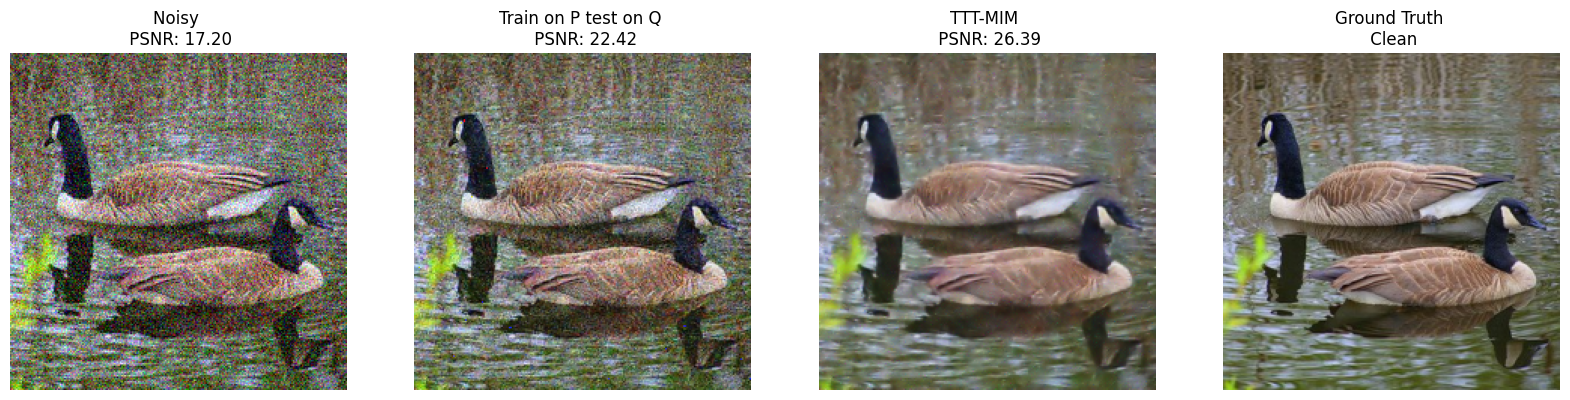

Input Noisy PSNR for imagenet: 17.57
TTT-MIM Output PSNR for imagenet: 27.28
[10/10]	Time  0.261 ( 0.898)	Data  0.009 ( 0.138)	Loss 7.8478e-03 (7.6949e-03)	PSNR 26.083 (27.275)


<Figure size 640x480 with 0 Axes>

In [2]:
# run TTT_MIM for single image
%run ttt_mim_online.py --dataset imagenet --noise-mode gaussian --noise-var 0.02 --pretrained model/0715_ttt_mim_unet_gn_0.005.pth.tar --niters 5 --lr 1e-4 --mask-ratio 0.4 --mask-patch-size 4 --denoise-loss pd --ImageNum 1 --gpu 0 testset/imagenet_subset

### Reproduction of Results for Adapting to Single Images

Run our method for test time training over different dataset and noise level scenarios to get the average PSNR values of the denoised images. The test is evaluated on 10 test images from each dataset with the selected hyperparameters.

In [3]:
import subprocess
from tabulate import tabulate
from tqdm import tqdm
def getInputOutputPSNR(command):
    """
    Run a script specified by the command and return the values of the desired variables.

    Args:
    - command: The command to run the script.

    Returns:
    - psnr_TTT_MIM: The average PSNR value of TTT_MIM for one scenario.
    - psnr_input_noisy: The average PSNR value of noisy input images for one scenario.
    """
    output = subprocess.check_output(command, shell=True)
    output = output.decode("utf-8")
    output_lines = output.split("\n")
    psnr_TTT_MIM = None
    psnr_input_noisy = None

    for line in output_lines:
        if line.startswith("Input Noisy PSNR"):
            psnr_input_noisy = float(line.split(":")[1].strip())
        elif line.startswith("TTT-MIM Output PSNR"):
            psnr_TTT_MIM = float(line.split(":")[1].strip())

    return psnr_TTT_MIM, psnr_input_noisy

def printPSNRTable(psnr_input_noisy_list, psnr_TTT_MIM_list):
  # print psnr result table for different dataset and noise level scenarios
  #Args:
  # psnr_input_noisy_list: List of average psnr of noisy input, order: SIDD, POLYU, FMDD, CT, FMRI, G0.01, G0.02, S&P, Poisson
  # psnr_TTT_MIM_list: List of average psnr of TTT_MIM output
  data = []
  scenarios = ["sidd", "polyu", "fmdd", "ct", "fastmri", "G0.01", "G0.02", "S&P", "Poisson", "Average"]
  num_rows = 3
  num_columns = len(scenarios) + 1
  # Iterate over rows
  for i in range(num_rows):
      row = []
      # Iterate over columns
      for j in range(num_columns): # Row {i+1}, Column {j+1}
          if i == 0:
            if j == 0:
              cell_value = "Scenarios"
            elif j == num_columns-1:
              cell_value = "Avg."
            else:
              cell_value = scenarios[j-1]
          elif i == 1:
            if j == 0:
              cell_value = "Input PSNR"
            elif j == num_columns-1:
              cell_value = round(sum(psnr_input_noisy_list)/len(psnr_input_noisy_list), 2)
            else:
              cell_value = psnr_input_noisy_list[j-1]
          elif i == 2:
            if j == 0:
              cell_value = "TTT-MIM Output PSNR"
            elif j == num_columns-1:
              cell_value = round(sum(psnr_TTT_MIM_list)/len(psnr_TTT_MIM_list),2)
            else:
              cell_value = psnr_TTT_MIM_list[j-1]
          row.append(cell_value)
      data.append(row)
  # Print the table
  table = tabulate(data, headers="firstrow", tablefmt="pipe")
  print("")
  print(table)

def getPSNRTable(lr_list, iterNum_list, mr_list, ms_list):
  """
    run TTT_MIM and get PSNR result table evaluated on test images for different dataset and noise level scenarios

    Args:
    - lr_list: learning rate
    - iterNum_list: number of gradient updates during test-time-training
    - mr_list: mask ratio
    - ms_list: mask patch size
    """
  noise_mode_list = ["", "", "", "gaussian", "gaussian", "gaussian", "gaussian", "sp", "poisson"]
  noise_var_list = [-1, -1, -1, 0.005, 0.005, 0.01, 0.02, 0.005, 0.005] # noise variance selection, not needed for natural noise
  dataset_list = ["sidd", "polyu", "fmdd", "ct", "fastmri", "imagenet", "imagenet", "imagenet", "imagenet"]
  testsetFolder_list = ["sidd_subset/", "polyu_subset/", "fmdd_subset/", "Phantom_10.npy", "fastmri_subset/gt/", "imagenet_subset/", "imagenet_subset/", "imagenet_subset/", "imagenet_subset/"]
  numExp = 9 # number of scenarios
  psnr_TTT_MIM_list = [0]*numExp
  psnr_input_noisy_list = [0]*numExp
  for i in tqdm(range(numExp), desc="Progress"):
    if dataset_list[i] == "sidd" or dataset_list[i] == "polyu" or dataset_list[i] == "fmdd":
      command = "python ttt_mim_online.py --dataset " + f"{dataset_list[i]}" + " --pretrained model/0715_ttt_mim_unet_gn_0.005.pth.tar" + " --niters " + f"{iterNum_list[i]}"  + f" --lr {lr_list[i]} --mask-ratio {mr_list[i]} --mask-patch-size {ms_list[i]}" + " --denoise-loss pd --ImageNum 0 --gpu 0 testset/" + testsetFolder_list[i]
    else:
      command = "python ttt_mim_online.py --dataset " + f"{dataset_list[i]}" + " --noise-mode "+ f"{noise_mode_list[i]}" + " --noise-var " + f"{noise_var_list[i]}" " --pretrained model/0715_ttt_mim_unet_gn_0.005.pth.tar " +  "--niters " + f"{iterNum_list[i]}"  + f" --lr {lr_list[i]} --mask-ratio {mr_list[i]} --mask-patch-size {ms_list[i]}" + " --denoise-loss pd --ImageNum 0 --gpu 0 testset/" + testsetFolder_list[i]
    # run TTM
    psnr_TTT_MIM_list[i], psnr_input_noisy_list[i] = getInputOutputPSNR(command)
  printPSNRTable(psnr_input_noisy_list, psnr_TTT_MIM_list)

In [4]:
# Set list of hyperparameters for different scenarios in the order of: SIDD, POLYU, FMDD, CT, FMRI, G0.01, G0.02, S&P, Poisson
lr = [1e-4, 5e-5, 5e-6, 1e-5, 1e-4, 1e-5, 5e-5, 5e-5, 1e-6] # learning rate
iterNum = [8, 8, 8, 8, 8, 8, 8, 8, 8] # number of gradient updates during test-time-training
mr = [0.3, 0.4, 0.5, 0.4, 0.01, 0.4, 0.4, 0.4, 0.1] # mask ratio
ms = [14, 4, 4, 4, 1, 4, 4, 4, 4] # mask patch size

getPSNRTable(lr, iterNum, mr, ms)

Progress: 100%|██████████| 9/9 [02:56<00:00, 19.56s/it]


| Scenarios           |   sidd |   polyu |   fmdd |    ct |   fastmri |   G0.01 |   G0.02 |   S&P |   Poisson |   Avg. |
|:--------------------|-------:|--------:|-------:|------:|----------:|--------:|--------:|------:|----------:|-------:|
| Input PSNR          |  25.49 |   36.86 |  39.1  | 36.86 |     23.54 |   20.4  |   17.57 |  18   |     27.77 |  27.29 |
| TTT-MIM Output PSNR |  33.63 |   38.44 |  44.68 | 46.05 |     29.63 |   29.78 |   27.41 |  25.9 |     32.84 |  34.26 |
